In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import src.SessionNavigator as SessionNavigator
import src.SessionProcessor as SessionProcessor
import path_entry
from scipy.stats import sem
from sklearn.svm import LinearSVC
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import pickle as pkl

In [2]:
def dict_to_array(dictionary, cv_count):
    arr = np.zeros((len(dictionary), cv_count))
    for key, value in dictionary.items():
        arr[key] = value
    return arr

CV_COUNT = 10

# path_entry.get_path() controls the file paths needed for this tutorial. 
# The paths returned by get_path() will need to be adjusted, as they are
# almost certainly unique to your computer
data_root, manifest_path, save_path = path_entry.get_path()
SAVE = False

navigator = SessionNavigator.SessionNavigator(manifest_path)
acronyms = ['VISp', 'VISl', 'VISal', 'VISrl', 'VISam', 'VISpm', 'LGd']
stim = 'drifting_gratings_contrast'
session_ids = navigator.find_sessions(acronyms, genotype="wt/wt", session_type="functional_connectivity")
#sessions = [navigator.load_session(session_id) for session_id in session_ids]
session = navigator.load_session(session_ids[0])
with open(f"{save_path}/{stim}__whole_burst_trains__session_{session_ids[0]}.pkl", 'rb') as f:
    bursts = pkl.load(f)
with open(f"{save_path}/{stim}__whole_single_trains__session_{session_ids[0]}.pkl", 'rb') as f:
    singles = pkl.load(f)

In [3]:
processor = SessionProcessor.SessionProcessor(session)
unshuffled = processor.construct_decoder('drifting_gratings_contrast', 'orientation', burst_dict=bursts, single_dict=singles, shuffle_trials=False)
shuffled = processor.construct_decoder('drifting_gratings_contrast', 'orientation', burst_dict=bursts, single_dict=singles, shuffle_trials=True)

In [4]:
processor.construct_psth(unshuffled)
processor.calculate_decoder_weights(unshuffled, cv_accuracy_scoring=True, cv_count=CV_COUNT)
processor.calculate_correlations(unshuffled)

processor.construct_psth(shuffled)
processor.calculate_decoder_weights(shuffled, cv_accuracy_scoring=True, cv_count=CV_COUNT)
processor.calculate_correlations(shuffled)

In [5]:
results = processor.results()
unshuffled_results = results[unshuffled]
shuffled_results = results[shuffled]
keys = unshuffled_results.keys()
(num_presentations, num_bins, num_units) = unshuffled_results["psths"]["whole"].shape
unit_ids = processor.all_units

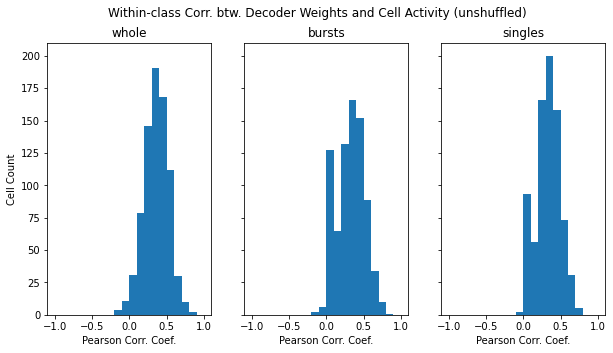

In [6]:
#                                         x   y
matplotlib.rcParams["figure.figsize"] = (10, 5)

correlation_diagonals = unshuffled_results["within_class_correlations"]

fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
plot_count = 0
for spike_train_type, diagonals in correlation_diagonals.items():
    diags = list(diagonals.values())
    image = ax[plot_count].hist(diags,bins=np.arange(-1, 1.1, 0.1))
    ax[plot_count].set_xlabel("Pearson Corr. Coef.")
    ax[plot_count].set_title(spike_train_type)
    plot_count += 1

ax[0].set_ylabel("Cell Count")
fig.suptitle("Within-class Corr. btw. Decoder Weights and Cell Activity (unshuffled)")
plt.show()

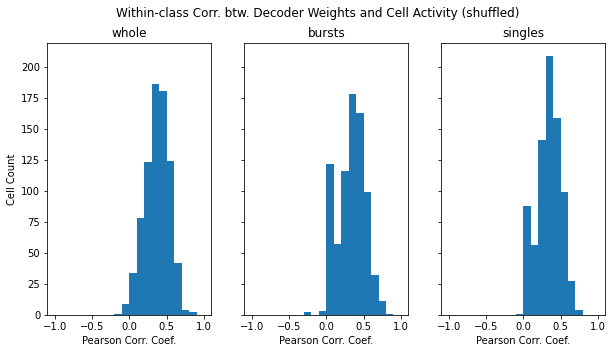

In [7]:
correlation_diagonals = shuffled_results["within_class_correlations"]

fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
plot_count = 0
for spike_train_type, diagonals in correlation_diagonals.items():
    diags = list(diagonals.values())
    image = ax[plot_count].hist(diags,bins=np.arange(-1, 1.1, 0.1))
    ax[plot_count].set_xlabel("Pearson Corr. Coef.")
    ax[plot_count].set_title(spike_train_type)
    plot_count += 1

ax[0].set_ylabel("Cell Count")
fig.suptitle("Within-class Corr. btw. Decoder Weights and Cell Activity (shuffled)")
plt.show()

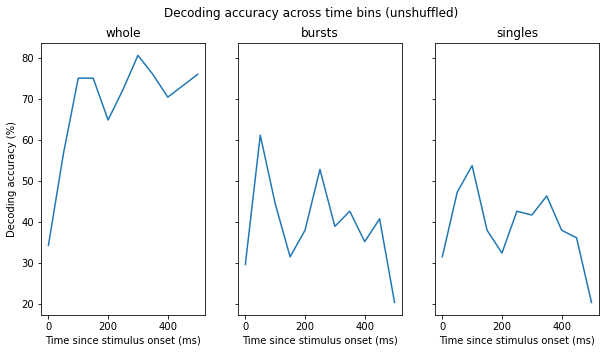

In [8]:
decoder = unshuffled_results["decoder"]
accuracy_scores = decoder.accuracy_scores
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)

plot_count = 0
for spike_train_type, accuracies in accuracy_scores.items():
    x = np.array(list(accuracies.keys()))
    y = np.array(list(accuracies.values()))
    image = ax[plot_count].plot(x*50, y*100)
    ax[plot_count].set_xlabel("Time since stimulus onset (ms)")
    ax[plot_count].set_title(spike_train_type)
    plot_count += 1
ax[0].set_ylabel("Decoding accuracy (%)")
fig.suptitle("Decoding accuracy across time bins (unshuffled)")
plt.show()

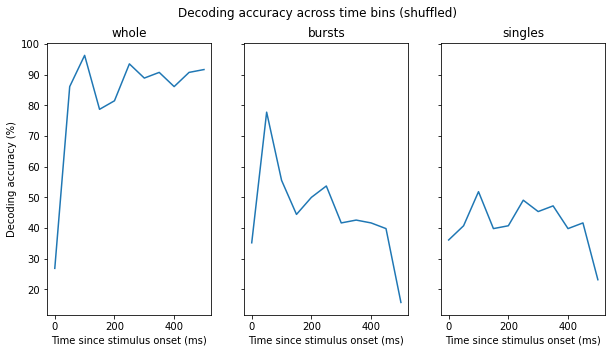

In [9]:
decoder = shuffled_results["decoder"]
accuracy_scores = decoder.accuracy_scores
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)

plot_count = 0
for spike_train_type, accuracies in accuracy_scores.items():
    x = np.array(list(accuracies.keys()))
    y = np.array(list(accuracies.values()))
    image = ax[plot_count].plot(x*50, y*100)
    ax[plot_count].set_xlabel("Time since stimulus onset (ms)")
    ax[plot_count].set_title(spike_train_type)
    plot_count += 1
ax[0].set_ylabel("Decoding accuracy (%)")
fig.suptitle("Decoding accuracy across time bins (shuffled)")
plt.show()

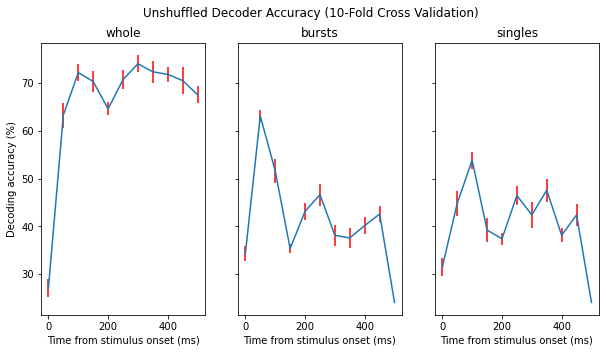

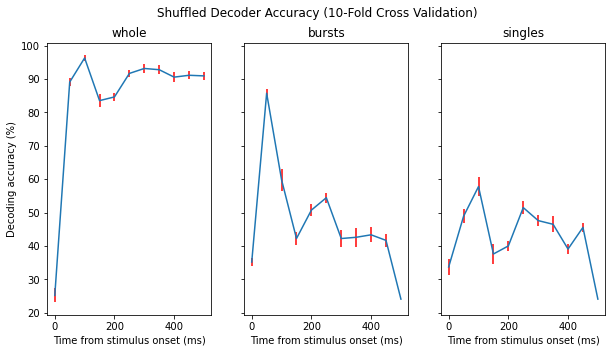

In [18]:
decoder = unshuffled_results["decoder"]
cv_accuracy_scores = decoder.cv_accuracy_scores

accuracies = cv_accuracy_scores["whole"]
num_bins = len(accuracies)
bins = np.array(list(range(num_bins)))*50
plot_count = 0
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
for spike_train_type, accuracies in cv_accuracy_scores.items():
    accuracies = dict_to_array(accuracies, CV_COUNT)
    unshuffled_sem = sem(accuracies, axis=1)

    ax[plot_count].errorbar(bins, accuracies.mean(axis=1)*100, unshuffled_sem*100, ecolor='r')#, fmt='none')
    #ax.errorbar(bins,thorough_shuffled_accuracies.mean(axis=1)*100,shuffled_sem*100, ecolor='g')#, fmt='none')
    ax[plot_count].set_xlabel('Time from stimulus onset (ms)')
    ax[plot_count].set_title(spike_train_type)
    plot_count += 1
ax[0].set_ylabel('Decoding accuracy (%)')
fig.suptitle('Unshuffled Decoder Accuracy (10-Fold Cross Validation)')
plt.show()

decoder = shuffled_results["decoder"]
cv_accuracy_scores = decoder.cv_accuracy_scores

accuracies = cv_accuracy_scores["whole"]
num_bins = len(accuracies)
bins = np.array(list(range(num_bins)))*50
plot_count = 0
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
for spike_train_type, accuracies in cv_accuracy_scores.items():
    accuracies = dict_to_array(accuracies, CV_COUNT)
    shuffled_sem = sem(accuracies, axis=1)
    
    ax[plot_count].errorbar(bins, accuracies.mean(axis=1)*100, shuffled_sem*100, ecolor='r')#, fmt='none')
    ax[plot_count].set_xlabel('Time from stimulus onset (ms)')
    ax[plot_count].set_title(spike_train_type)
    plot_count += 1

ax[0].set_ylabel('Decoding accuracy (%)')
fig.suptitle('Shuffled Decoder Accuracy (10-Fold Cross Validation)')
plt.show()

In [ ]:
unshuffled_weights = unshuffled_results["decoder"].weights_by_cell
shuffled_weights = shuffled_results["decoder"].weights_by_cell

k = 0
differences = np.zeros(len(unit_ids))
for unit_id in unit_ids:
    current_unshuffled_weights = unshuffled_weights[unit_id]#np.sort(unshuffled_weights[unit_id])
    current_shuffled_weights = shuffled_weights[unit_id]#np.sort(shuffled_weights[unit_id])
    differences[k] = (current_unshuffled_weights - current_shuffled_weights).mean()
    k += 1
differences.mean()

1.431626760927654e-05